# Judicial Outcomes Project

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
bailCopy = pd.read_csv('Weekly_Historical_Criminal_20241102.txt', sep = '	', encoding = 'latin-1')

<ipython-input-2-a965d8ca026c>:1: DtypeWarning: Columns (8,15,16,17,22,37,44,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  bailCopy = pd.read_csv('Weekly_Historical_Criminal_20241102.txt', sep = '	', encoding = 'latin-1')


In [ ]:
# run this cell to reset bail dataframe to original format w/o reloading
bail = bailCopy.copy()

## Data Cleaning

In [ ]:
# give columns more meaningful names
bail.columns = ['courtDivInd', 'caseNum', 'fileDate', 'instrumentType',
                'caseDisp', 'court', 'caseStatus', 'defStatus', 'bondAmt',
                'curOffense', 'curOffenseLit', 'curLevelDeg', 'comOffense',
                'comOffenseLit', 'comLevelDeg', 'gjOffense', 'gjOffenseLit',
                'gjLevelDeg', 'nextAppearanceDate', 'docketType',
                'nextAppearanceReason', 'defName', 'defSPN', 'defRace', 'defSex',
                'defDOB', 'defStNum', 'defStName', 'defAptNum', 'defCity',
                'defState', 'defZIP', 'atyName', 'atySPN', 'atyConnectionCode',
                'atyConnectionLit', 'compName', 'compAgency',
                'offenseReportNum', 'dispDate', 'disposition', 'caseNumDivInd',
                'sentence', 'defCitizen', 'bondException', 'gjDate',
                'gjCourt', 'gjCDP', 'defBirthState']

In [ ]:
# drop irrelevant/repetitive columns
bail.drop(columns = ['curOffense', 'comOffense', 'comOffenseLit', 'comLevelDeg',
                     'gjOffense', 'gjOffenseLit', 'gjLevelDeg',
                     'nextAppearanceDate', 'defStNum', 'defStName', 'defAptNum',
                     'caseNumDivInd', 'atySPN', 'atyConnectionCode',
                     'compName', 'gjDate', 'gjCourt', 'gjCDP'], inplace = True)

In [ ]:
# recode key columns to meaningful values
bail.loc[:, 'courtDivInd'] = bail['courtDivInd'].map({2: 'MISDEMEANOR',
                                               3: 'FELONY'})

bail.loc[:, 'defRace'] = bail['defRace'].map({'A': 'ASIAN/PACIFIC ISLANDER',
                                       'B': 'BLACK',
                                       'I': 'NATIVE AMERICAN',
                                       'M': 'MULTIRACIAL',
                                       'U': 'UNKNOWN',
                                       'W': 'WHITE'})

<ipython-input-53-a34887f9d636>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['MISDEMEANOR' 'MISDEMEANOR' 'MISDEMEANOR' ... 'FELONY' 'FELONY' 'FELONY']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  bail.loc[:, 'courtDivInd'] = bail['courtDivInd'].map({2: 'MISDEMEANOR',


In [ ]:
# remove rows reflecting past actions for same case/defendant
bail = bail.drop_duplicates(subset = ['caseNum', 'defSPN'], keep = 'last')

In [ ]:
# recode unknown sex to NaN
bail['defSex'] = bail['defSex'].apply(lambda x : np.nan if x in [' ', 'U'] else x)

# recode unknown race to NaN
bail['defRace'] = bail['defRace'].apply(lambda x : np.nan if x == 'UNKNOWN' else x)

# recode citizenship status to Yes, No, or NaN
bail['defCitizen'] = bail['defCitizen'].apply(lambda x : (x if x in ['Y', 'N'] else None))

In [ ]:
# simplified attorney connection variable
bail['atyConnectionLit'] = bail['atyConnectionLit'].fillna('')

bail.loc[bail['atyConnectionLit'].str.contains('APPOINTED|PUBLIC|FOR DEFENDANT',
                                               regex = True),
         'atyConnectionLit'] = 'Appointed'
bail.loc[bail['atyConnectionLit'].str.contains('HIRED'),
         'atyConnectionLit'] = 'Hired'
bail.loc[bail['atyConnectionLit'].str.contains('TEMPORARY'),
         'atyConnectionLit'] = 'Temporary'

### Missing Values

In [ ]:
# drop rows without sentence (outcome variable)
bail = bail[bail['sentence'].notna()]

In [ ]:
# identify remaining columns with many missing values
bailna = bail.isna().sum() / len(bail)
bailna[bailna > .3]

,0
bondException,0.981019


Bond exception naturally missing values because it applies only to small number of cases (those with exception to normal bond setting)

## Feature Engineering

In [ ]:
bail.columns

Index(['courtDivInd', 'caseNum', 'fileDate', 'instrumentType', 'caseDisp',
       'court', 'caseStatus', 'defStatus', 'bondAmt', 'curOffenseLit',
       'curLevelDeg', 'docketType', 'nextAppearanceReason', 'defName',
       'defSPN', 'defRace', 'defSex', 'defDOB', 'defCity', 'defState',
       'defZIP', 'atyName', 'atyConnectionLit', 'compAgency',
       'offenseReportNum', 'dispDate', 'disposition', 'sentence', 'defCitizen',
       'bondException', 'defBirthState'],
      dtype='object')

In [ ]:
# categorical columns
catcols = ['courtDivInd', 'instrumentType', 'caseDisp', 'caseStatus',
           'defStatus', 'curOffenseLit', 'curLevelDeg', 'docketType',
           'nextAppearanceReason', 'defName', 'defRace', 'defSex', 'defCity',
           'defState', 'atyName', 'atyConnectionLit', 'compAgency',
           'offenseReportNum', 'disposition', 'sentence']
bail[catcols] = bail[catcols].astype(str)

# integer columns
intcols = ['caseNum', 'court']
bail[intcols] = bail[intcols].astype(int)

# float columns
bail['bondAmt'] = pd.to_numeric(bail['bondAmt'], errors = 'coerce')

# date/time columns
bail['fileDate'] = pd.to_datetime(bail['fileDate'], format = '%Y%m%d', errors = 'coerce')
bail['defDOB'] = pd.to_datetime(bail['defDOB'], format = '%Y%m%d', errors = 'coerce')
bail['dispDate'] = pd.to_datetime(bail['dispDate'], format = '%Y%m%d', errors = 'coerce')

In [ ]:
# calculate age
bail['defDays'] = bail['dispDate'] - bail['defDOB']

# convert timedelta64[ns] to years
bail['defAge'] = bail['defDays'].dt.days / 365.25

bail = bail[bail['defAge'].notna()]

len(bail)

In [ ]:
# define age bins and labels
age_bins = [0, 18, 21, 25, 35, 50, 65, 100]  # Bins for age ranges
age_labels = ['0-18', '19-21', '22-25','26-35', '36-50', '51-65', '66+']  # Corresponding labels

# Create age categories using pd.cut
bail['defAgeCategory'] = pd.cut(bail['defAge'], bins=age_bins, labels=age_labels, right=True)

# Display the results
bail['defAgeCategory'].astype(str)

In [ ]:
# new charge degree variable
bail.loc[:,'curDegree'] = bail['curLevelDeg'].str.split().map(
    lambda x : x[1] if isinstance(x, list) and len(x) > 1 else None)
bail.drop(columns = 'curLevelDeg', inplace = True)

In [ ]:
# past offenses count variable
bail['pastOffenseNum'] = bail.groupby('defSPN').cumcount()

# drop defendent SPN (no longer necessary)
bail.drop(columns = 'defSPN', inplace = True)

# subset data to district courts now that county court offenses accounted for
bail = bail[bail['court'] > 16]

In [ ]:
# guilty plea variable
bail['guiltyPlea'] = bail['disposition'].apply(
    lambda x: x in ['CONVICTION-PLEA OF GUILTY', 'GUILTY PLEA - JURY VERDICT',
                    'PROBATION-PLEA OF GUILTY', 'GUILTY PLEA-JURY VERDICT', 'GUILTY PLEA-NO JURY',
                    'GUILTY PLEA - 12.44 B MISDEMEANOR', 'LESSER OFF. NOLO PLEA - NO JURY'
                    'CONVICTION-PLEA GUIL/NOLO CONT', 'CONVICTION-NOLO CONTENDERE',
                    'PROBATION-NOLO CONTENDERE', 'NOLO CONTENDRE PLEA - NO JURY (CC)',
                    'NOLO-CONTENDERE PLEA - 12.44 B MISD', 'LESSER OFF. GUILTY PLEA - JURY VERDICT',
                    'LESSER OFF. GUILTY PLEA - NO JURY', 'DEFERRED ADJUD OF GUILT',
                    'DEFERRED ADJUDICATION OF GU', 'DEFR ADJ GLT', 'DEF ADJ GLT ADJUDICATED',
                    'DEF ADJ GLT REVOKED', 'DEFERRED ADJUDICATION TERMINATED',
                    'PROB/DADJ TERMED - DEF DECEASED', 'CONDITIONAL DISCHARGE',
                    'CONDITIONAL DISCHARGE GRANT', 'CONDITIONAL DISCHARGE REVOKED',
                    'MNT TO REVOKE CONDITION DISCHRG DISM'])

In [ ]:
# bond denied variable
bail['bondDenied'] = bail['bondException'] == 'BOND DENIED'

In [ ]:
# drop covariate rows with missing values
bail = bail.dropna(subset=['courtDivInd', 'curDegree', 'pastOffenseNum', 'guiltyPlea'])

# create charge division and degree variable
bail.loc[:, 'courtDivDegree'] = bail['courtDivInd'] + ' ' + bail['curDegree']

# map values of sentence type for consistency
def replace_numbers_with_letters(text):
    return text.replace("1", "A").replace("2", "B").replace("3", "C")

# transform division and degree column
bail.loc[:, 'courtDivDegree'] = bail['courtDivDegree'].apply(replace_numbers_with_letters)

In [ ]:
# defendant has attorney variable
bail.loc[:, 'hasAttorney'] = (bail['atyName'] != 'nan').astype(int)
bail.drop(columns = 'atyName', inplace = True)

In [ ]:
# in state and in city variables
bail.loc[:, 'defInState'] = bail['defState'] == 'TX'
bail.loc[:, 'defInCity'] = bail['defCity'] == 'HOUSTON'

In [ ]:
# split the "Last Name" and "First Name Middle Name" by ", "
bail[['lastName', 'firstMiddle']] = bail['defName'].str.split(', ', expand=True)

# split "First Name" and "Middle Name"
bail[['firstName', 'middleName']] = bail['firstMiddle'].str.extract(r'(\S+)(?:\s+(.*))?')

# drop unnecessary "First Name Middle Name" column
bail.drop(columns=['firstMiddle'], inplace = True)

### Extract Sentence Variables

In [ ]:
## Divide Sentence into separate components
# Three new component features: jail time, probation time, fine amount

def extract_jail_time(sentence):
    parts = sentence.split(', ')  # Split sentence by ', '
    for part in parts:
        if any(keyword in part for keyword in ["HCJ", "CONFINEMENT", "TDC"]):
            return part  # Return the part that contains hcj_time
        elif "LIFE" in part:
          return "LIFE SENTENCE"
    return "NO JAIL TIME"  # Default if no hcj_time found

def extract_fine_amount(sentence):
    parts = sentence.split(', ')  # Split sentence by ', '
    for part in parts:
        if part.startswith('$'):
            return float(part.split()[0][1:])  # Return the fine amount
    return 0  # Default if no "FINE" found

def extract_probation(sentence):
    parts = sentence.split(', ')  # Split sentence by ', '
    for part in parts:
        if "PROBATION" in part:
            return part  # Return the part that contains "PROBATION"
    return "NO PROBATION"  # Default if no "PROBATION" found

In [ ]:
# Apply the function to create a new 'jail_time' column
bail['jail_time'] = bail['sentence'].apply(extract_jail_time)
# Apply the function to create a new 'fine_amount' column
bail['fine_amount'] = bail['sentence'].apply(extract_fine_amount)
# Apply the function to create a new 'probation' column
bail['probation'] = bail['sentence'].apply(extract_probation)

In [ ]:
# operationalize life sentences as equivalent to 25 years in prison
bail.loc[bail['sentence'].str.contains('LIFE'), 'jail_time'] = '25 YEARS'

In [ ]:
def sentence_to_day(jail):
  # initialize sentence in days
    sentence = 0

    parts = jail.split(' ')
    if "YEARS" in parts:
        sentence += int(parts[0]) * 365
    elif "MONTH" in parts or "MONTHS" in parts:
        sentence += int(parts[0]) * 30
    elif "DAYS" in parts:
        sentence += int(parts[0])

    return sentence

bail['jail_days'] = bail['jail_time'].apply(sentence_to_day)
bail['probation_days'] = bail['probation'].apply(sentence_to_day)

### TAP Score

In [ ]:
# fill all missing values as NaN object
bail.replace('^(nan| *)$', np.nan, regex = True, inplace = True)

In [ ]:
# compute sentence harshness TAP scores according to paper:
# https://www.ojp.gov/pdffiles1/nij/grants/204024.pdf

def calculate_tap_score(row):
    fine_amount, probation_days, jail_days = row['fine_amount'], row['probation_days'], row['jail_days']

    if fine_amount == 0 and probation_days == 0 and jail_days == 0:
        return 0
    elif fine_amount > 0 and probation_days == 0 and jail_days == 0:
        return 1
    elif probation_days <= 365 and jail_days == 0:
        return 1
    elif probation_days <= 365 * 3 and probation_days > 365 and jail_days == 0:
        return 2
    elif probation_days > 365 * 3 and jail_days == 0:
        return 3
    elif (probation_days > 0 and jail_days > 0) or (jail_days <= 365 * (7/12) and jail_days > 0):
        return 4
    elif jail_days <= 365 and jail_days > 365 * (7/12):
        return 5
    elif jail_days <= 365 * 2 and jail_days > 365:
        return 7
    elif jail_days <= 365 * 3 and jail_days > 365 * 2:
        return 10
    elif jail_days <= 365 * 4 and jail_days > 365 * 3:
        return 12
    elif jail_days <= 365 * 5 and jail_days > 365 * 4:
        return 14
    elif jail_days <= 365 * 10 and jail_days > 365 * 5:
        return 25
    elif jail_days > 365 * 10:
        return 50
    else:
        return -1  # default return value for unmatched cases

# add 'TAP' column
bail['TAP'] = bail.apply(calculate_tap_score, axis=1)

In [ ]:
from scipy import stats

# perform Box-Cox transformation to address skew of TAP values
bail['tap_boxcox'], lambda_ = stats.boxcox(bail['TAP'] + 1)

## Data Visualization

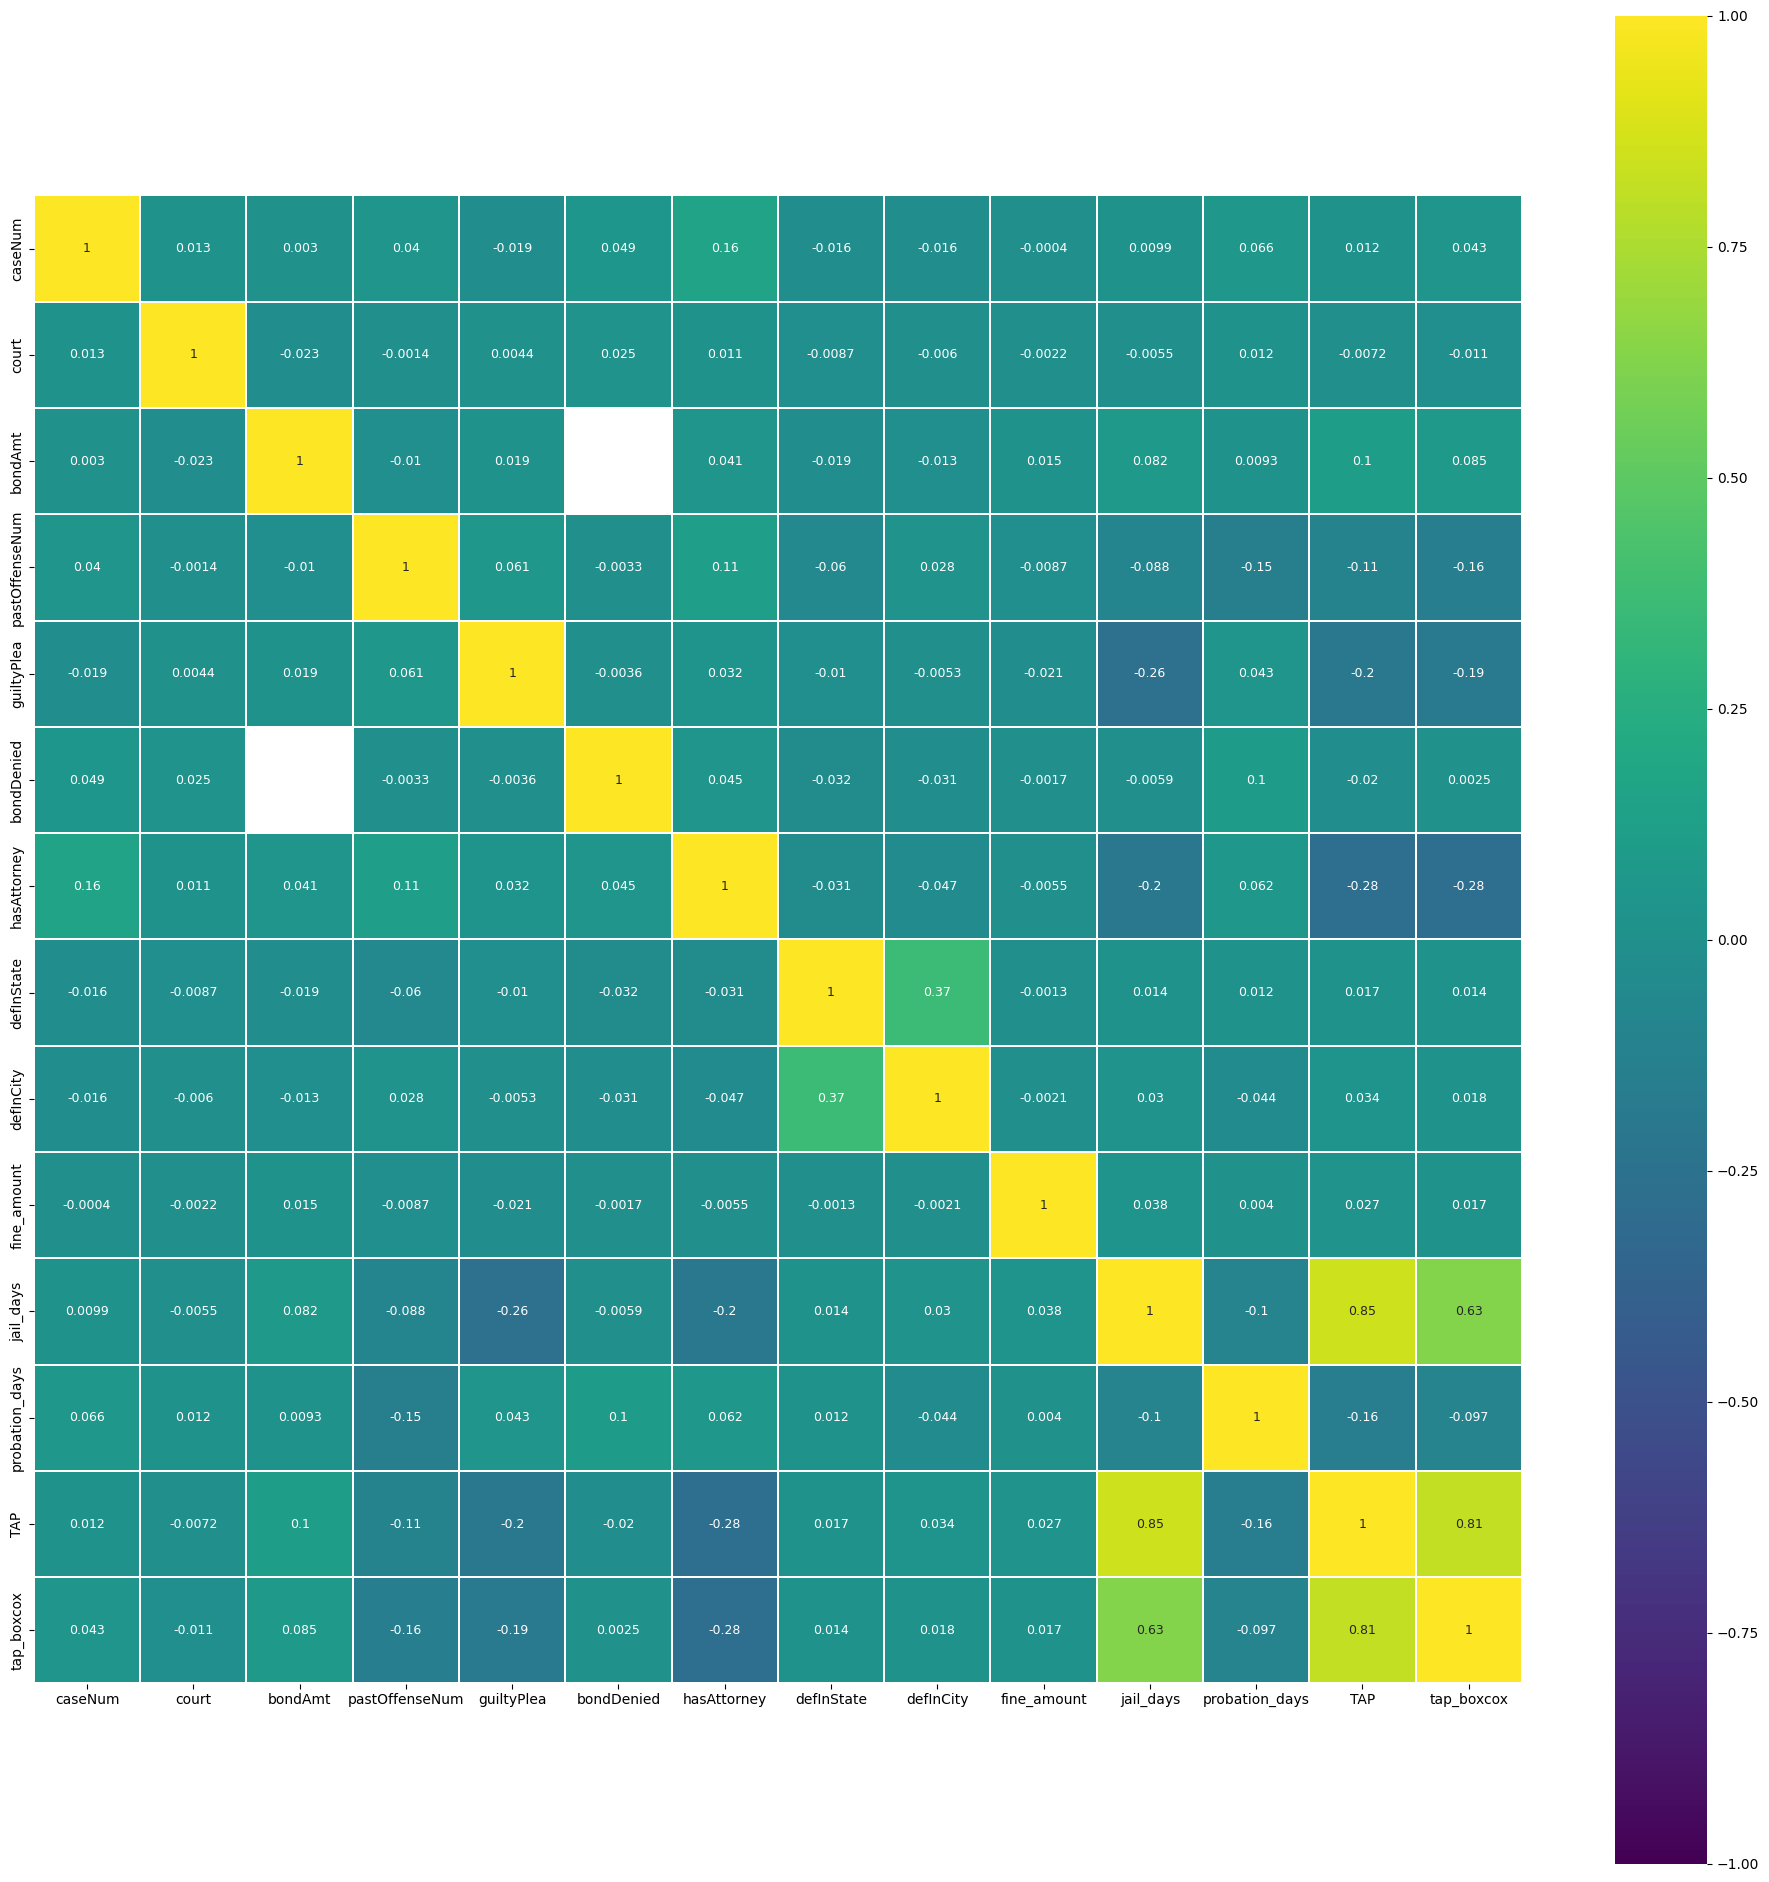

In [ ]:
# create correlation heatmap of numeric features
bail_corr = bail.corr(numeric_only = True)
plt.figure(figsize=(24, 24))

sns.heatmap(bail_corr,
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 9}, square=True);

array([[<Axes: title={'center': 'caseNum'}>,
        <Axes: title={'center': 'fileDate'}>,
        <Axes: title={'center': 'court'}>,
        <Axes: title={'center': 'bondAmt'}>],
       [<Axes: title={'center': 'defDOB'}>,
        <Axes: title={'center': 'dispDate'}>,
        <Axes: title={'center': 'pastOffenseNum'}>,
        <Axes: title={'center': 'hasAttorney'}>],
       [<Axes: title={'center': 'fine_amount'}>,
        <Axes: title={'center': 'jail_days'}>,
        <Axes: title={'center': 'probation_days'}>,
        <Axes: title={'center': 'TAP'}>],
       [<Axes: title={'center': 'tap_boxcox'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

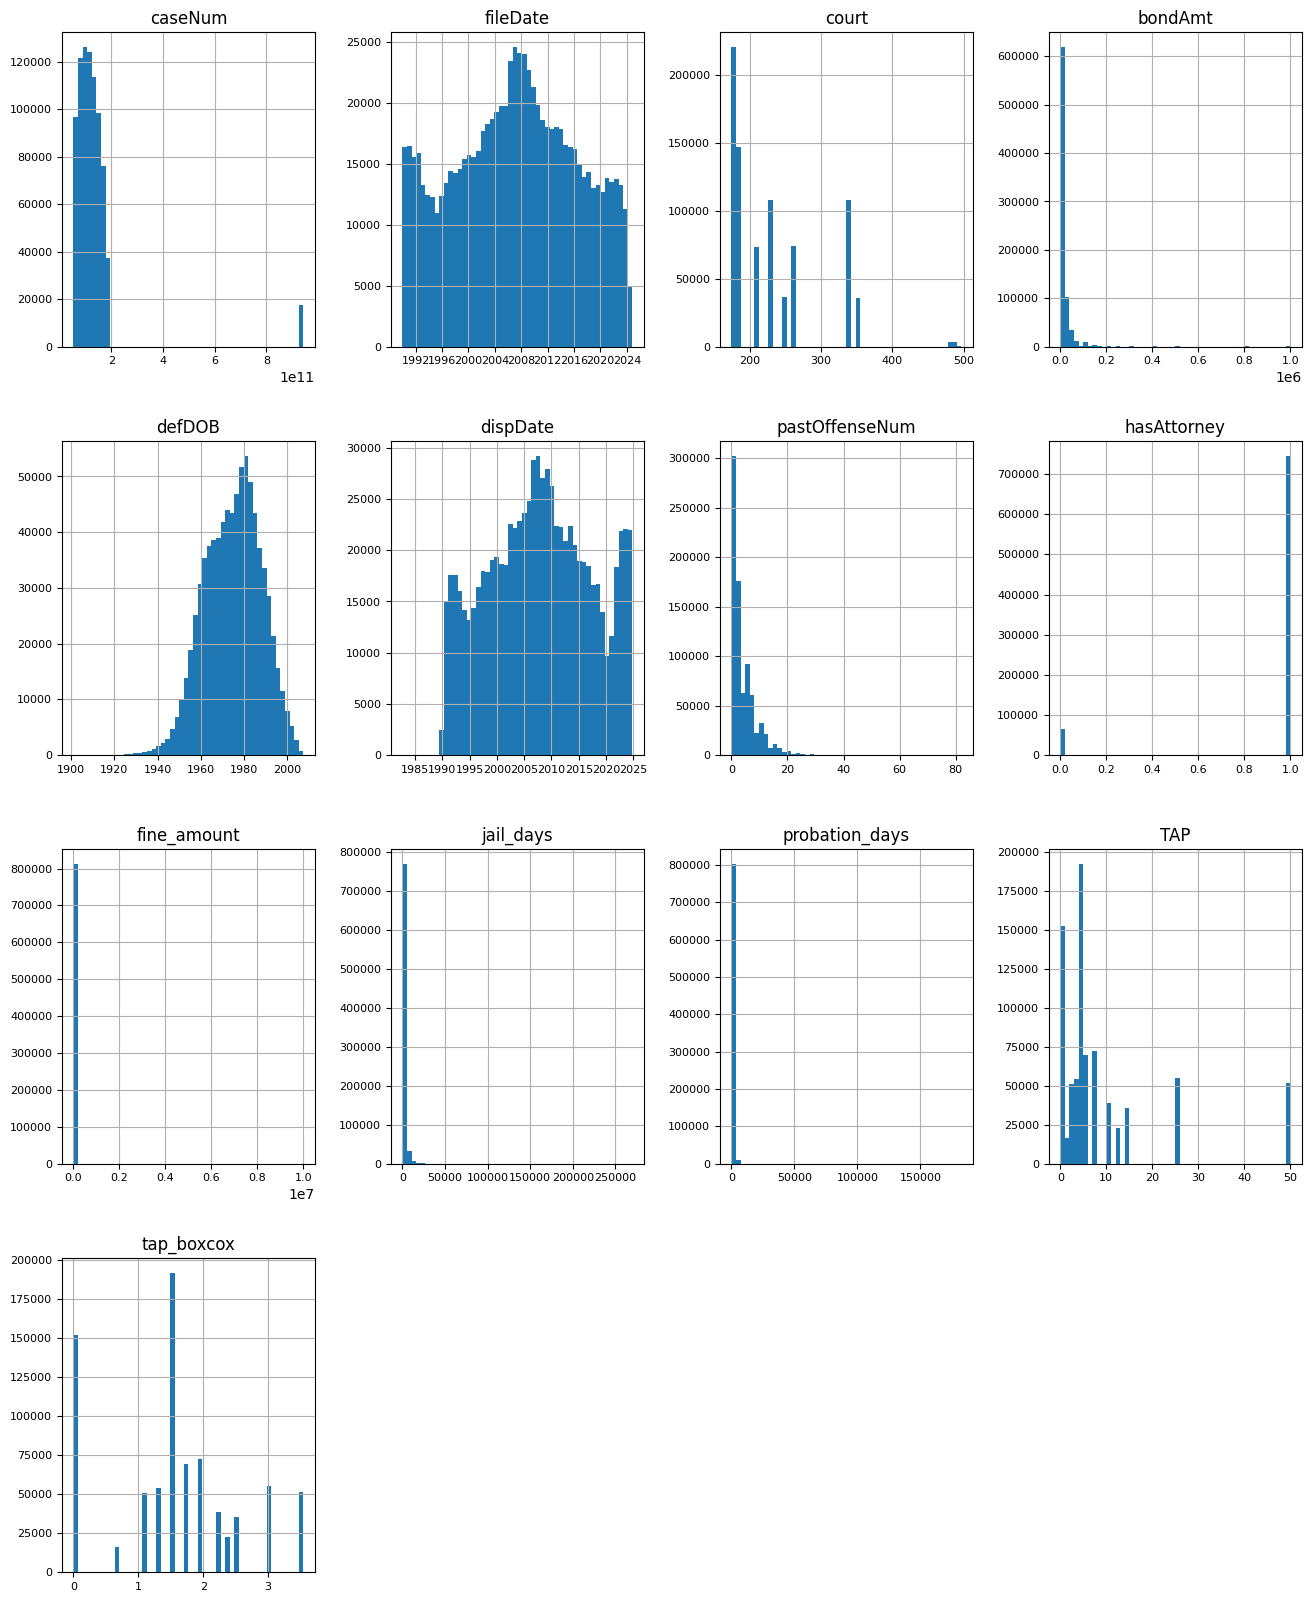

In [ ]:
# create histogram for numeric features
bail.hist(figsize=(16,20), bins = 50, xlabelsize=8, ylabelsize=8)

In [ ]:
# plotting histogram of jail sentences (under 200 days) by race
white_data = bail[(bail['defRace'] == 'WHITE') & (bail['jail_days'] <= 200)]
black_data = bail[(bail['defRace'] == 'BLACK') & (bail['jail_days'] <= 200)]

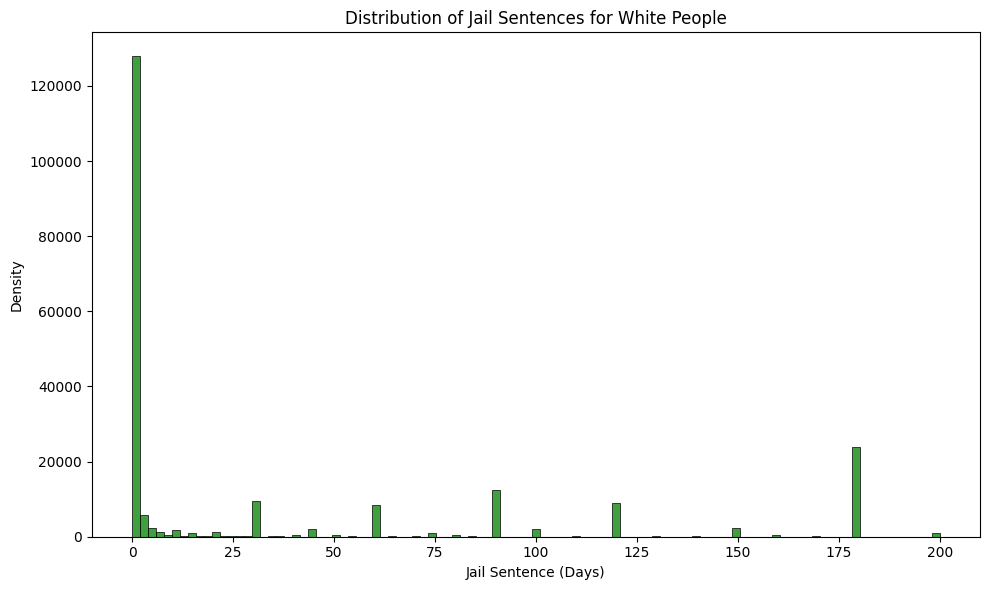

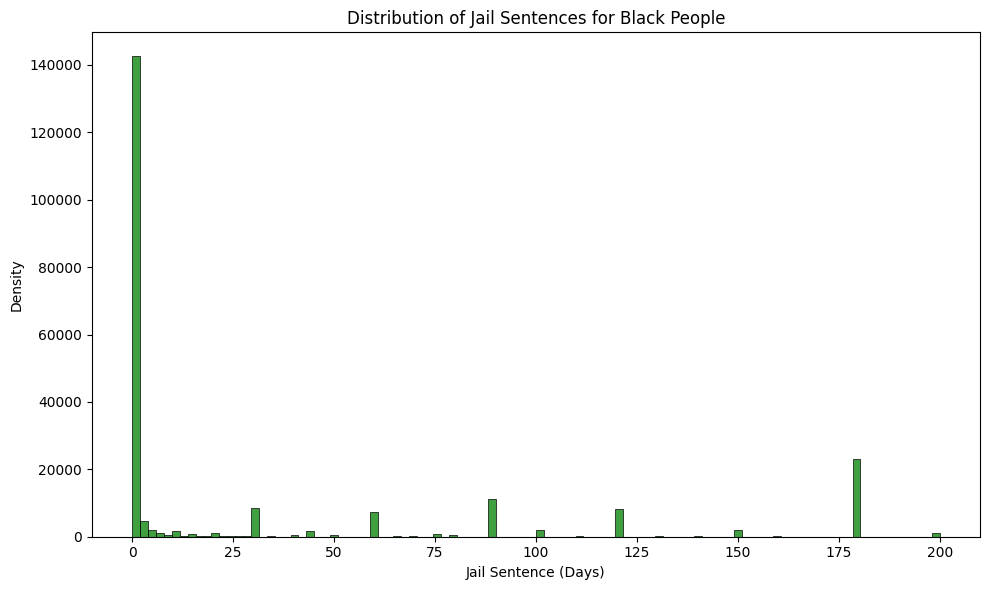

In [ ]:
# white defendants
plt.figure(figsize=(10, 6))
sns.histplot(white_data['jail_days'], color='g')
plt.xlabel("Jail Sentence (Days)")
plt.ylabel("Density")
plt.title("Distribution of Jail Sentences for White People")
plt.tight_layout()
plt.show()

# black defendants
plt.figure(figsize=(10, 6))
sns.histplot(black_data['jail_days'], color='g')
plt.xlabel("Jail Sentence (Days)")
plt.ylabel("Density")
plt.title("Distribution of Jail Sentences for Black People")
plt.tight_layout()
plt.show()

In [ ]:
bail.loc[bail['defRace'] == 'WHITE', 'jail_days'].describe().round(2)

,jail_days
count,393001.00
mean,1003.50
std,2343.04
min,0.00
25%,0.00
50%,180.00
75%,1095.00
max,270000.00


In [ ]:
bail.loc[bail['defRace'] == 'BLACK', 'jail_days'].describe().round(2)

,jail_days
count,406715.00
mean,1144.48
std,2596.65
min,0.00
25%,0.00
50%,180.00
75%,1095.00
max,43800.00


# Data Exploration

In [ ]:
# check number of recidivism cases
len(bail[bail['pastOffenseNum']>0]) / len(bail) * 100

In [ ]:
# check recidivism rate by race
result = (
    bail.groupby('defRace')
    .apply(lambda group: len(group[group['pastOffenseNum'] > 0]) / len(group) * 100)
    .reset_index(name='PercentWithPastOffenses')
)

# display results
print(result)

In [ ]:
# calculate percentage of guilty pleas by defSex
result = (
    bail.groupby('defSex')['guiltyPlea']
    .mean()
    .reset_index(name='PercentGuiltyPlea')
)

# convert to percentage
result['PercentGuiltyPlea'] *= 100

# display results
print(result)

In [ ]:
# calculate percentage of guilty pleas by defRace
result = (
    bail.groupby('defRace')['guiltyPlea']
    .mean()
    .reset_index(name='PercentGuiltyPlea')
)

# convert to percentage
result['PercentGuiltyPlea'] *= 100

# display results
print(result)

In [ ]:
# calculate percentage of guilty pleas by defCitizen
result = (
    bail.groupby('defCitizen')['guiltyPlea']
    .mean()
    .reset_index(name='PercentGuiltyPlea')
)

# convert to percentage
result['PercentGuiltyPlea'] *= 100

# display results
print(result)

In [ ]:
# check TAP by age category
bail.groupby(['defAgeCategory'])['TAP'].mean()

## Regression Analysis

In [ ]:
# subset data to just those filed 2010-2020
bail = bail[(bail['fileDate'] >= pd.to_datetime('20100101', format='%Y%m%d')) &
 (bail['fileDate'] < pd.to_datetime('20200101', format='%Y%m%d'))]

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# baseline model of always predicting mean TAP score

# baseline MSE
mse = mean_squared_error(bail['tap_boxcox'], bail.shape[0] * [bail['tap_boxcox'].mean()])
print("Baseline MSE:", mse)

# baseline R²
r2 = r2_score(bail['tap_boxcox'], bail.shape[0] * [bail['tap_boxcox'].mean()])
print("Baseline Adjusted R²:",
      1 - (1 - r2) *
       (bail.shape[0] - 1) /
        (bail.shape[0] - bail.shape[1] - 1))

Baseline MSE: 0.9123165643479777
Baseline R²: -0.00019543448059033963


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate

# build linear regression models w/ 10-fold cross validation

# SIMPLE model - harshness ~ offenseleveldegree + numpastoffenses + guiltyplea

X = bail[['courtDivDegree', 'pastOffenseNum', 'guiltyPlea']]
X = X[~X.isna().any(axis=1)]
y = bail['tap_boxcox']

# onehot encode object variables for regression
object_cols = X.select_dtypes(include='object').columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(drop='first', sparse_output=False),
                   object_cols)], remainder='passthrough'
)
X = preprocessor.fit_transform(X)

# 10-fold cross validation
m1_scores = cross_validate(LinearRegression(), X, y, cv=5,
                           scoring=['r2', 'neg_mean_squared_error'],
                           return_train_score=True, return_estimator=True)

# extract MSE scores and convert them to positive values
train_mse_scores = -m1_scores['train_neg_mean_squared_error']
test_mse_scores = -m1_scores['test_neg_mean_squared_error']
# extract R² scores
train_r2_scores = m1_scores['train_r2']
test_r2_scores = m1_scores['test_r2']

print("Average Training MSE:", np.mean(train_mse_scores))
print("Average Testing MSE:", np.mean(test_mse_scores))
print("Average Training Adjusted R²:",
      1 - (1 - np.mean(train_r2_scores)) *
       (X.shape[0] - 1) /
       (X.shape[0] - X.shape[1] - 1))
print("Average Testing Adjusted R²:",
      1 - (1 - np.mean(test_r2_scores)) *
       (X.shape[0] - 1) /
        (X.shape[0] - X.shape[1] - 1))

Average Training MSE: 0.5450235830014232
Average Testing MSE: 0.5486057694567461
Average Training Adjusted R²: 0.40215298582335557
Average Testing Adjusted R²: 0.39034304320829316


In [ ]:
# generate coefficient tables for SIMPLE model
from sklearn import datasets, linear_model
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X)
X2 = X2.astype(float)
est = sm.OLS(y, X2)
est2 = est.fit()

# SIMPLE model coefficient names
xname = ['CONSTANT', 'FELONY B', 'FELONY C', 'FELONY S',
         'PAST OFFENSE NUMBER', 'GUILTY PLEA']
yname = 'TAP SCORE'
print(est2.summary(xname = xname, yname = yname))

                            OLS Regression Results                            
Dep. Variable:              TAP SCORE   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                 3.168e+04
Date:                Thu, 12 Dec 2024   Prob (F-statistic):               0.00
Time:                        02:15:58   Log-Likelihood:            -2.6268e+05
No. Observations:              235420   AIC:                         5.254e+05
Df Residuals:                  235414   BIC:                         5.254e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
CONSTANT                2.6811    

In [ ]:
## ENHANCED model - harshness ~ offenseleveldegree + numpastoffenses +
##                               guiltyplea + race + sex + citizen

X = bail[['courtDivDegree', 'pastOffenseNum', 'guiltyPlea',
          'defRace', 'defSex', 'defCitizen']]
X = X[~X.isna().any(axis=1)]
y = bail.loc[X.index, 'tap_boxcox']

# onehot encode object variables for regression
object_cols = X.select_dtypes(include='object').columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(drop='first', sparse_output=False),
                   object_cols)], remainder='passthrough'
)
X = preprocessor.fit_transform(X)

# 10-fold cross validation
m2_scores = cross_validate(LinearRegression(), X, y, cv=10,
                           scoring=['r2', 'neg_mean_squared_error'],
                           return_train_score=True, return_estimator=True)

# extract MSE scores and convert them to positive values
train_mse_scores = -m2_scores['train_neg_mean_squared_error']
test_mse_scores = -m2_scores['test_neg_mean_squared_error']
# extract R² scores
train_r2_scores = m2_scores['train_r2']
test_r2_scores = m2_scores['test_r2']

print("Average Training MSE:", np.mean(train_mse_scores))
print("Average Testing MSE:", np.mean(test_mse_scores))
print("Average Training Adjusted R²:",
      1 - (1 - np.mean(train_r2_scores)) *
       (X.shape[0] - 1) /
       (X.shape[0] - X.shape[1] - 1))
print("Average Testing Adjusted R²:",
      1 - (1 - np.mean(test_r2_scores)) *
       (X.shape[0] - 1) /
        (X.shape[0] - X.shape[1] - 1))

Average Training MSE: 0.5447358931500184
Average Testing MSE: 0.5462799383239566
Average Training Adjusted R²: 0.41013690308851236
Average Testing Adjusted R²: 0.4001014818074121


In [ ]:
# generate coefficient tables for ENHANCED model
X2 = sm.add_constant(X)
X2 = X2.astype(float)
est = sm.OLS(y, X2)
est2 = est.fit()

# ENHANCED model coefficient names
xname = ['CONSTANT', 'FELONY B', 'FELONY C', 'FELONY S',
         'PAST OFFENSE NUMBER', 'GUILTY PLEA',
         'BLACK', 'NATIVE AMERICAN', 'WHITE', 'FEMALE', 'CITIZEN']
yname = 'TAP SCORE'
print(est2.summary(xname = xname, yname = yname))

                            OLS Regression Results                            
Dep. Variable:              TAP SCORE   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                 1.508e+04
Date:                Thu, 12 Dec 2024   Prob (F-statistic):               0.00
Time:                        02:16:03   Log-Likelihood:            -2.4181e+05
No. Observations:              216816   AIC:                         4.836e+05
Df Residuals:                  216805   BIC:                         4.838e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
CONSTANT                2.5766    